<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Word2vec _skip-grams_ implementation<a id="top"></a>

<i><small>Author: Alberto Díaz Álvarez<br>Last update: 2023-05-25</small></i></div>

***

## Introduction

We start with the most important of all: _Word embedding techniques_ is a way of saying _representing words numerically_ but with more hooks. And having said that, we are going to program a process of learning _embeddings_ from text corpora. We will focus on a technique called _Word2Vec_, although we have already seen that there are more.

Word2vec_ is based on a neural network that generates the matrix using supervised training on a classification problem. The article where the method is presented is [Efficient Estimation of Word Representations in Vector Space (Mikolov et al.,2013)](https://arxiv.org/pdf/1301.3781.pdf) and it is a method that is quite successfully used to measure **syntactic and semantic similarity of words**.

The article explores two different models: _Continuous Bag-of-Words_ and _Skip-gram_. The latter is the most commonly used, and will be the one we will look at in this exercise.

The idea of the _Skip-gram_ is the following: given a word (which we will call _context word_), we want to train a model such that it is able to predict a word belonging to a window of size $N$. For example, assuming a window of size $N = 3$ and given the following sentence:

> All those <span style="color:red">moments will be</span> **lost** <span style="color:red">in time like</span> tears in rain

The _context word_ would be **lost**, and we would train the model to predict one of the existing words within the specified window, i.e., one of `['moments', 'will', 'be', 'in', 'time', 'like']`.

## Goals

In this _notebook_ we will create an _embedding_ from the _skip-gram_ technique of _Word2Vec_.

## Libraries and configuration

Next we will import the libraries that will be used throughout the notebook.

In [1]:
import os

import numpy as np
import pandas as pd
import requests
import tensorflow as tf

import matplotlib.pyplot as plt

2023-05-25 18:33:52.914030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


We will also configure some parameters to adapt the graphic presentation.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

And create the necessary directories in case they have not been created previously

In [3]:
os.makedirs('tmp', exist_ok=True)

***

## Corpus construction

We will use the Amazon Reviews dataset (from https://nijianmo.github.io/amazon/index.html, not the most current, but useful for us) to train the model. More specifically, we will use the small subset of the category "Software".

In [4]:
DATASET_URL = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Software_5.json.gz'
DATASET_ZIP = 'tmp/Software_5.json.gz'

# Download the remote file if it does not exist
if not os.path.exists(DATASET_ZIP):
    with open(DATASET_ZIP, 'wb') as f:
        print(f'Downloading {DATASET_ZIP}...')
        r = requests.get(DATASET_URL, verify=False)
        f.write(r.content)
        print('OK')

Once downloaded, we can proceed to load the dataset. For our purpose (creating an _embedding_), we don't care about the output of the model or the id of the examples; we want the texts, so we are going to extract them, eliminating the blanks at the beginning and at the end.

In [5]:
corpus = pd.read_json(DATASET_ZIP, lines=True)
corpus = corpus['reviewText'].astype(str).str.strip()
corpus.head()

0    I've been using Dreamweaver (and it's predeces...
1    The demo is done with the PC version, with ref...
2    If you've been wanting to learn how to create ...
3    I've been creating websites with Dreamweaver f...
4    I decided (after trying a number of other prod...
Name: reviewText, dtype: object

The variable `corpus` points to an array with all the sentences in our set. We are going to tokenize each of the comments, converting them into a list of words. For this we will use the `tokenizer` function included in keras, although it is important to understand that this step is not trivial and will probably require a lot of preprocessing to have a quality dataset (e.g. lemmatization, $n$-grams, ...).

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)

At this point, our tokenizer has processed all the comments and extracted all the words, assigning an identifier to each one. We will store them in two dictionaries so that we can convert them into integers (to identify the word) and into words (once we have the integer

In [7]:
word_index = tokenizer.word_index
index_word = {index: word for word, index in word_index.items()}

print(f'word2id: {dict(list(word_index.items())[0:4])} ...')
print(f'id2word: {dict(list(index_word.items())[0:4])} ...')

word2id: {'the': 1, 'to': 2, 'and': 3, 'a': 4} ...
id2word: {1: 'the', 2: 'to', 3: 'and', 4: 'a'} ...


Finally, each of the comments in the corpus will be transformed into a list of integers where each token in the corpus will be replaced by the integer it represents. We will also obtain the size of our vocabulary from the number of identified words.

To convert a text string into a sequence of words we can use the Keras function `tf.keras.preprocessing.text.text_to_word_sequence(text)`. From there getting the index of each word is trivial.

In [8]:
sentences = [
    [word_index[w] for w in tf.keras.preprocessing.text.text_to_word_sequence(text)]
    for text in corpus
]
vocab_size = len(word_index) + 1

print(f'Corpus sentences: {len(sentences)} sentences')
print(f'Vocabulary Size: {vocab_size} words')
print(f'Sentence example:')
print(f'- {corpus[5]}')
print(f'- {sentences[5]}')

Corpus sentences: 12805 sentences
Vocabulary Size: 28871 words
Sentence example:
- The video is well-paced and delivered in an understandable manner.  It allows you to work with the software while watching and following the directions of instructor Candyce Mairs.  To me, the book is more of a reference guide, something I would access with a specific need or question, because overall I learn better by seeing and doing than by reading.  The video starts with the basics and builds logically.  This is everything you want in a teaching video/book!
- [1, 91, 8, 73, 7984, 3, 2691, 13, 34, 4963, 2713, 6, 429, 9, 2, 77, 14, 1, 22, 143, 1697, 3, 1083, 1, 1304, 7, 5540, 14492, 14493, 2, 43, 1, 659, 8, 36, 7, 4, 1688, 997, 197, 5, 62, 296, 14, 4, 856, 80, 26, 928, 99, 307, 5, 278, 115, 72, 1628, 3, 298, 58, 72, 763, 1, 91, 1378, 14, 1, 1430, 3, 3909, 7985, 12, 8, 207, 9, 94, 13, 4, 2607, 91, 659]


## Skip-gram generator

Now we will generate the _skip-grams_. The idea is, from all the sentences in the corpus (each `sentence` of `sentences`) and given an action window, to extract its context (the surrounding words) to determine for each pair of words whether they are contextual or not.

In [9]:
WINDOW_SIZE = 5

x_train, y_train = [], []
for sentence in sentences:
    pairs, are_contextual = tf.keras.preprocessing.sequence.skipgrams(
        sentence,
        vocabulary_size=vocab_size,
        window_size=WINDOW_SIZE,
    )
    x_train.extend(pairs)
    y_train.extend(are_contextual)

x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1, 1)
dataset = np.hstack((x_train, y_train))

print(f'Dataset shape: {dataset.shape}')
print(dataset)

Dataset shape: (44861036, 3)
[[  379   104     1]
 [ 4436 10425     0]
 [  212     7     1]
 ...
 [   35     7     1]
 [ 2534    27     1]
 [  260 18938     0]]


It can be seen that it has been generated, for each pair of words, whether they are (1) or not (0) contextual. This is because the `skipgrams` function transforms a sequence of words (actually of integers) into tuples of the form:

- `(word, word in context)`, label 1 (positive, are contextual).
- `(word, random word outside of context)`, label 0 (not contextual).

## Model creation and training

We already have a dataset with inputs and their respective outputs. Now the objective is to train a model that is able to determine if two words belong to the same context.

To do this we will create an embedding layer that will transform the words into their feature vector. The words will be those that are or are not contextual, and it will determine how close (more contextual) or far (less contextual) they are, using a distance measure (scalar product).

Finally, the output of the network will be a single neuron that will be activated or not if they are contextual.

This architecture will force the more contextual words to be closer together, and therefore their feature vectors to be more similar. The weights matrix of the embedding layer is thus expected to converge to a representation of the word features.

In [12]:
EMBEDDING_DIM = 5

# Inputs to the model
input_target = tf.keras.layers.Input((1,))
input_context = tf.keras.layers.Input((1,))

# Common layers (including the embedding)
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    input_length=1,
    name='embedding',
)

reshape_layer = tf.keras.layers.Reshape((EMBEDDING_DIM, 1))

# Model architecture
target_embedding = embedding_layer(input_target)
target_embedding = reshape_layer(target_embedding)
target_embedding = tf.keras.layers.Dropout(0.1)(target_embedding)

context_embedding = embedding_layer(input_context)
context_embedding = reshape_layer(context_embedding)
context_embedding = tf.keras.layers.Dropout(0.1)(context_embedding)

hidden_layer = tf.keras.layers.Dot(axes=1, normalize=True)([target_embedding, context_embedding])
hidden_layer = tf.keras.layers.Reshape((1,))(hidden_layer)

output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

model = tf.keras.Model(inputs=[input_target, input_context], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         144355      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 5, 1)         0           embedding[0][0]            

Now we only have to train the model. To do so, we will train it with each of the _skip-grams_ generated previously. We will use a validation separation of 10% and train for 10 epochs.

**This step is very expensive**, and can take quite a few minutes (hours), so either we have a powerful machine, or we better leave it here.

In [14]:
history = model.fit([dataset[:, 0], dataset[:, 1]], dataset[:, 2], batch_size=8*32768, epochs=50)

Epoch 1/50
172/172 [==============================] - 10s 43ms/step - loss: 0.7094
Epoch 2/50
172/172 [==============================] - 7s 42ms/step - loss: 0.6926
Epoch 3/50
172/172 [==============================] - 7s 44ms/step - loss: 0.6601
Epoch 4/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6459
Epoch 5/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6417
Epoch 6/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6386
Epoch 7/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6358
Epoch 8/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6334
Epoch 9/50
172/172 [==============================] - 7s 44ms/step - loss: 0.6314
Epoch 10/50
172/172 [==============================] - 8s 44ms/step - loss: 0.6296
Epoch 11/50
172/172 [==============================] - 7s 42ms/step - loss: 0.6281
Epoch 12/50
172/172 [==============================] - 7s 43ms/step - loss: 0.6266
Epoch 13/50


Let's take a look at the training progress:

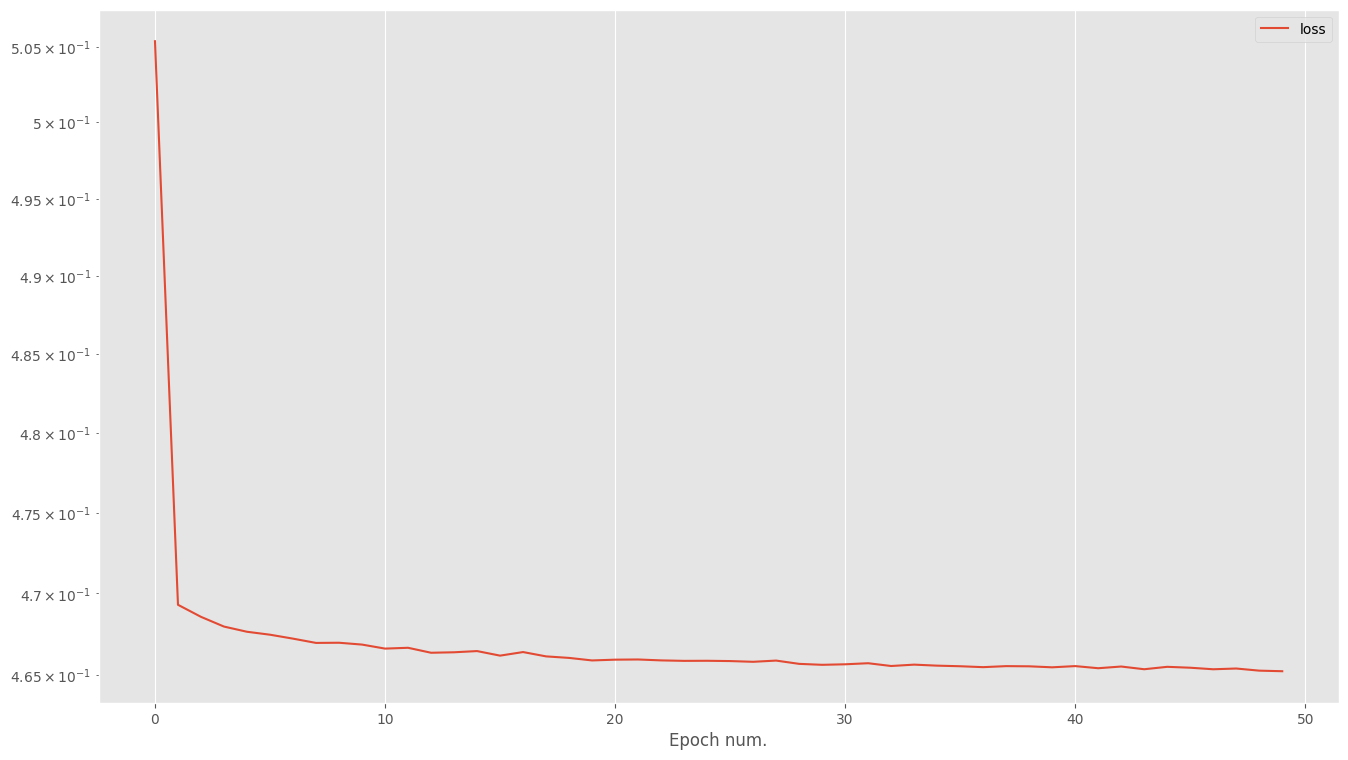

In [ ]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## Embeddings

Once the model is trained, we already have a matrix with the weights of the features for each word. To see a representation we can take them directly and print them in a dataframe.

In [ ]:
weights = embedding_layer.get_weights()[0][1:]

df = pd.DataFrame(weights, index=index_word.values())
df.head(10)

,0,1,2,3,4
the,-0.364053,0.356604,-0.354759,0.351620,-0.349185
to,-0.352917,0.344202,-0.352536,0.358578,-0.352921
and,-0.343665,0.355549,-0.348232,0.341795,-0.361806
a,-0.348880,0.351700,-0.345310,0.352640,-0.353859
i,-0.356252,0.351378,-0.348276,0.352210,-0.347581
it,-0.345027,0.355942,-0.341955,0.359849,-0.339238
of,-0.351463,0.352795,-0.341441,0.344868,-0.351368
is,-0.337272,0.359276,-0.344927,0.345425,-0.363942
you,-0.346580,0.354544,-0.345489,0.346459,-0.345674
for,-0.341945,0.342833,-0.347269,0.343963,-0.350499


Let's make a search with the most similar words to a given one using, for example, the Euclidean distance of its vectors

In [ ]:
NUM_CLOSEST_WORDS = 10
WORD = 'man'

v1 = weights[word_index[WORD] - 1]
words = sorted(
    [word for word in word_index.keys()],
    key=lambda w: np.linalg.norm(v1 - weights[word_index[w]-1])
)
df.loc[words[:NUM_CLOSEST_WORDS + 1], :]

,0,1,2,3,4
man,-0.012862,1.162959,-0.100296,0.350839,-0.044519
acceptable,0.006858,1.156448,-0.114493,0.299758,-0.023211
filling,-0.014182,1.097864,-0.072980,0.336073,-0.046303
secret,-0.020728,1.128907,-0.048650,0.410157,-0.095325
hooked,-0.080764,1.142155,-0.037088,0.338558,0.003862
blown,-0.072587,1.164829,-0.041216,0.306790,0.007192
french,-0.059561,1.164077,-0.015824,0.296998,-0.072423
beautifully,0.005477,1.222516,-0.058297,0.264353,-0.060509
similarly,0.004995,1.216108,-0.033617,0.271561,-0.082319
nobody,-0.009628,1.205266,-0.016262,0.270898,-0.052234


## Conclusions

In summary, we have implemented embedding using the _skip-grams_ technique of _word2vec_ and have demonstrated its effectiveness in representing words more meaningfully in a vector space. This technique is able to capture the semantics of words, representing them in a vector space of lower dimension than it would occupy with an _one-hot_ representation.

Note, we also realized that **it is a very expensive technique**, and therefore does not make much sense (in general) since we have many ready-made _embeddings_ available for download.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>